In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import *

In [2]:
nx = 4
nu = 2
T = 40
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs_act = 1.5
obs0 = Obstacle(10, 8, 2, obs_act, 'Obs0')
obs1 = Obstacle(3.5, 2, 1, obs_act, 'Obs1')
obs2 = Obstacle(8, 7, 1, obs_act, 'Obs2')
obs3 = Obstacle(4.5, 6, 1, obs_act, 'Obs3')
obs4 = Obstacle(8, 3, 1, obs_act, 'Obs4')
# obs5 = Obstacle(6, 7.5, 1, obs_act, 'Obs5')
# obs6 = Obstacle(7.5, 3, 1, obs_act, 'Obs6')
# obs7 = Obstacle(5, 1, 1, obs_act, 'Obs7')
# obs8 = Obstacle(2.5, 2, 1, obs_act, 'Obs8')
obs_set = [obs1, obs2, obs3, obs4]#, obs5, obs6, obs7, obs8]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)
cost_set.add_cost(obs4)
# cost_set.add_cost(obs5)
# cost_set.add_cost(obs6)
# cost_set.add_cost(obs7)
# cost_set.add_cost(obs8)

nr = cost_set.nr

In [3]:
# Desired Weights
w_run_possibles = np.array([10, 1., 1., 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000])
w_term_possibles = np.array([2000, 1., 1., 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()

10 Trajectories Collected
Trajectory 16 Rejected
20 Trajectories Collected
Trajectory 26 Rejected
30 Trajectories Collected
Trajectory 38 Rejected
Trajectory 40 Rejected
40 Trajectories Collected


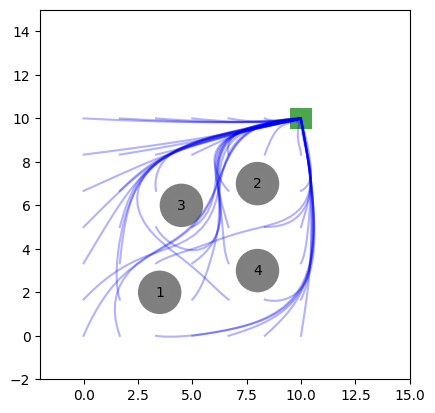

0


In [4]:
samples = 7
xlims = [0, 10]
ylims = [0, 10]
x0 = start_point
u0 = np.array([0.0, 0.0])
timeStep = 5e-2
max_iter = 500
XS_Set_optimal, US_Set_optimal = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_des, timeStep, max_iter, with_callback = False)
xs_optimal = XS_Set_optimal[0]
us_optimal = US_Set_optimal[0]
print(plot_tested_model(XS_Set_optimal, obs_set, target_high))

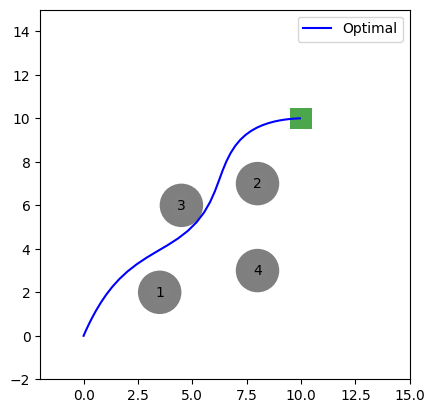

In [5]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [6]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

xs_non_optimal, us_non_optimal, sqp_non_opt = get_results_from_model(cost_set, x0, u0, T, w_bad, timeStep, max_iter, with_callback = False)

In [61]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_set, us_set, dt, Beta = 0.001, Lambda = 0.001):
    nr = cost_set.nr
    costs = np.zeros(len(xs_set))
    feats = np.zeros(shape=(len(xs_set),nr))
    alphas = np.zeros(len(xs_set))
    factor_alpha = 1e-4
    output = 0
    x_opt = xs_set[0]; u_opt = us_set[0]
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    for i, (X, U) in enumerate(zip(xs_set, us_set)):
        feats[i,:] = cost_set.cum_feat(X,U,dt)
        costs[i] = np.max([np.nextafter(0,1),cost_set.traj_cost(X, U, x[:nr], x[nr:], dt)])
    opt_cost = costs[0]
    opt_feat = feats[0,:]
    for i, feat in enumerate(feats):
        # alphas[i] = (feat/opt_feat)*np.exp(-np.linalg.norm(opt_feat - feat))
        alphas[i] = np.exp(-np.linalg.norm(opt_feat - feat))
    alphas /= np.sum(alphas)
    norm_a = np.linalg.norm(alphas[1:])
    num = np.max([np.nextafter(0,1), np.exp(-opt_cost)])
    den += num
    for alpha, cost in zip(alphas[1:],costs[1:]):
        # den += np.max([np.nextafter(0,1), alpha*np.exp(-cost)])
        den += np.max([np.nextafter(0,1), np.exp(-cost)])
    output -= np.log(num/den)
    output -= Beta*norm_a
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_2(x, cost_set, xs_set, us_set, dt, Beta = 0.001, Lambda = 0.001):
    nr = cost_set.nr
    costs = np.zeros(len(xs_set))
    alphas = np.zeros(len(xs_set))
    output = 0
    x_opt = xs_set[0]; u_opt = us_set[0]
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    for i, (X, U) in enumerate(zip(xs_set, us_set)):
        costs[i] = np.max([np.nextafter(0,1),cost_set.traj_cost(X, U, x[:nr], x[nr:], dt)])
    opt_cost = costs[0]
    for i, cost in enumerate(costs):
        alphas[i] = np.max([0.5,(cost/opt_cost)*np.exp(-np.linalg.norm(opt_cost - cost))])
    norm_a = np.linalg.norm(alphas[1:])
    num = np.max([np.nextafter(0,1), np.exp(-opt_cost)])
    den += num
    for alpha, cost in zip(alphas[1:],costs[1:]):
        den += alpha*np.max([np.nextafter(0,1), np.exp(-cost)])
    output -= np.log(num/den)
    output += Beta*norm_a
    output += Lambda*np.linalg.norm(x)
    return output

In [78]:
dt = timeStep
Lambda = 0.01
Beta = 1.0
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 2, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10

w0 = w_bad
# w0 = np.ones_like(w_bad)
w_prev = w0
it = 0
max_set_size = 3 # Must be grater than 2, None for all
# it_max_IRL = max_set_size + 1
it_max_IRL = 20
it_max_sqp = 5

xs = []
us = []
ws = []
Fcns= []
Cost_Diffs = []
W_Diffs = []
Traj_Diffs = []
Alphas = []
xs_non_optimal_set = []
us_non_optimal_set = []
xs.append(np.vstack(xs_optimal).copy()); us.append(np.vstack(us_optimal).copy())
xs.append(np.vstack(xs_non_optimal).copy()); us.append(np.vstack(us_non_optimal).copy())
xs_set = xs.copy(); us_set = us.copy()

ws.append(w_bad)

init_choices = ['bad','optimal','previous']
stochastic = False
w_tol = 0.0001
traj_tol = 1e-10
w_diff = 1
traj_diff = 1
e = 1
norm_w = 1
opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], dt)
while norm_w > w_tol and it < it_max_IRL:
    
    # With simple regulation: ||w||
    res = minimize(fcn_w, 
                   w0, 
                   args=(cost_set, xs_set, us_set, dt, Beta, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    
    w_loop = res.x.copy()
    w_loop /= np.max(w_loop)

    # fcn_value = fcn_w(w_loop, cost_set, xs, us, dt, Lambda)
    fcn_value = 0.0
    Fcns.append(fcn_value)
    w_run = w_loop[:nr]
    w_term = w_loop[nr:]
    for i in range(T):
        sqp_non_opt.problem.runningModels[i].differential.model.costWeights = w_run
    sqp_non_opt.problem.terminalModel.differential.model.costWeights = w_term
    sqp_non_opt.with_callbacks=False

    # initial = random.choice(init_choices)
    initial = 'previous'
    if initial == 'previous':
        # Warm-Start with previous trajectory
        xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
        us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    elif initial == 'optimal':
        # Warm-Start with optimal trajectory
        xs_init = [xs_optimal[i] for i in range(T+1)]
        us_init = [us_optimal[i] for i in range(T)]
    elif initial == 'bad':
        # Warm-Start with zero trajectory
        xs_init = [x0 for i in range(T+1)]
        us_init = [u0 for i in range(T)]
    
    done = sqp_non_opt.solve(xs_init, us_init, it_max_sqp)
    new_traj_cost = sqp_non_opt.cost
    traj_alpha = (new_traj_cost/opt_traj_cost)*np.exp(-np.linalg.norm(opt_traj_cost - new_traj_cost))
    opt_diff = (cost_set.traj_cost(sqp_non_opt.xs.copy(), sqp_non_opt.us.copy(), w_des[:nr], w_des[nr:], dt)- opt_traj_cost)**2
    w_diff = np.linalg.norm(w_loop - w_prev)
    traj_diff = (sqp_non_opt.cost - cost_set.traj_cost(xs_optimal, us_optimal, w_loop[:nr], w_loop[nr:], dt))**2
    
    # Add the trajectory to the set
    xs.append(np.vstack(sqp_non_opt.xs.tolist().copy()))
    us.append(np.vstack(sqp_non_opt.us.tolist().copy()))
    ws.append(w_loop.copy())

    # # Add a noisy trajectory to the set
    # scale = 5*traj_alpha
    # # scale = 5.0
    # noisy_u = np.vstack(sqp_non_opt.us.tolist().copy())+np.random.normal(0.0,scale,np.stack(sqp_non_opt.us.tolist()).shape)
    # us.append(noisy_u)
    # xs.append(np.stack(sqp_non_opt.problem.rollout([noisy_u[i] for i in range(T)])))

    if max_set_size is None:
        xs_set = xs
        us_set = us
    else:
        if len(xs_set) <= max_set_size:
            xs_set = xs
            us_set = us
        else:
            if not stochastic:
                xs_set = xs[-max_set_size:]; xs_set[0] = xs[0]
                us_set = us[-max_set_size:]; us_set[0] = us[0]
            else:
                xs_set = random.choices(xs, k=max_set_size)
                us_set = random.choices(us, k=max_set_size)
        
    Cost_Diffs.append(opt_diff)
    W_Diffs.append(w_diff)
    Traj_Diffs.append(traj_diff)
    Alphas.append(traj_alpha)
    BetaTerm = Beta*np.linalg.norm(np.stack(Alphas)[-len(xs_set)+1:])
    LambdaTerm = Lambda*np.linalg.norm(w_loop)
    if it > 0:
        print('Beta Term: {:.4f} || Lambda Term: {:.4f} || Weight Diff: {:.4f} || Traj Diff: {:.4f}, || Optimal Diff: {:.4f}'.format(
            BetaTerm, LambdaTerm, w_diff, traj_diff, opt_diff
        ))
    
    # Initial W for IRL as previous weights
    w0 = w_loop.copy()
    norm_w = opt_diff
    w_prev = w0
    it += 1
    if it == it_max_IRL-1:
        options['maxiter'] = 20
        xs_set = xs
        us_set = us

print(res)
w_irl = res.x/np.max(res.x)

Beta Term: 0.0000 || Lambda Term: 0.0124 || Weight Diff: 0.2231 || Traj Diff: 4988.9198, || Optimal Diff: 68.2940
Beta Term: 0.0005 || Lambda Term: 0.0102 || Weight Diff: 0.6778 || Traj Diff: 15.4425, || Optimal Diff: 0.3530
Beta Term: 0.0055 || Lambda Term: 0.0108 || Weight Diff: 0.3157 || Traj Diff: 0.0032, || Optimal Diff: 0.0713
Beta Term: 0.0208 || Lambda Term: 0.0108 || Weight Diff: 0.0633 || Traj Diff: 1.6218, || Optimal Diff: 1.6864
Beta Term: 0.0222 || Lambda Term: 0.0108 || Weight Diff: 0.0014 || Traj Diff: 0.9108, || Optimal Diff: 0.1562
Beta Term: 0.0239 || Lambda Term: 0.0108 || Weight Diff: 0.0011 || Traj Diff: 1.1003, || Optimal Diff: 0.1366
Beta Term: 0.0634 || Lambda Term: 0.0115 || Weight Diff: 0.2034 || Traj Diff: 0.0636, || Optimal Diff: 0.0313
Beta Term: 0.4010 || Lambda Term: 0.0115 || Weight Diff: 0.0067 || Traj Diff: 0.0049, || Optimal Diff: 0.5662
Beta Term: 0.9372 || Lambda Term: 0.0115 || Weight Diff: 0.0016 || Traj Diff: 0.1100, || Optimal Diff: 0.0001
Beta 

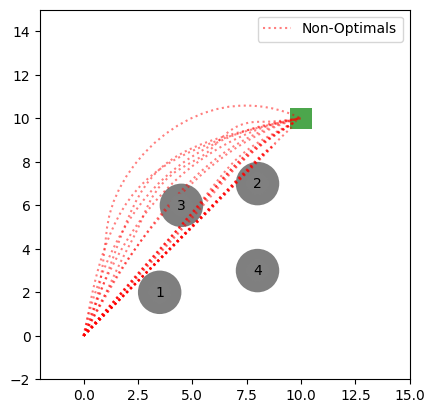

In [79]:
plot_1_set(xs[1:], obs_set, target_high, label='Non-Optimals', linemap_traj='r:', linemap_set='r:')

In [80]:
w_irl = res.x/np.max(res.x)
w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.005247728881889906
Terminal ||  Desired:  1.0 IRL:  1.0

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  0.00022949218305023315
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  1.0 IRL:  0.0994583998765734
Terminal ||  Desired:  0.5 IRL:  0.0

Obs2 :
Running ||  Desired:  1.0 IRL:  0.6134434297687704
Terminal ||  Desired:  0.5 IRL:  0.11953159549551812

Obs3 :
Running ||  Desired:  1.0 IRL:  0.4244963663173942
Terminal ||  Desired:  0.5 IRL:  0.0006562519289039076

Obs4 :
Running ||  Desired:  1.0 IRL:  0.0
Terminal ||  Desired:  0.5 IRL:  0.0



In [81]:
print('Desired:                 ', fcn_w(w_des, cost_set, xs, us, dt, Lambda)) 
print('IRL:                     ', fcn_w(w_irl, cost_set, xs, us, dt, Lambda))
print('')
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))

Desired:                  2.5968426450878432
IRL:                      2.6222437975388995

Desired Trajectory Cost:  1.3353346709574858
with IRL Weight:          0.9127588821206427


10 Trajectories Collected
Trajectory 16 Rejected
20 Trajectories Collected
Trajectory 26 Rejected
30 Trajectories Collected
Trajectory 38 Rejected
Trajectory 40 Rejected
40 Trajectories Collected


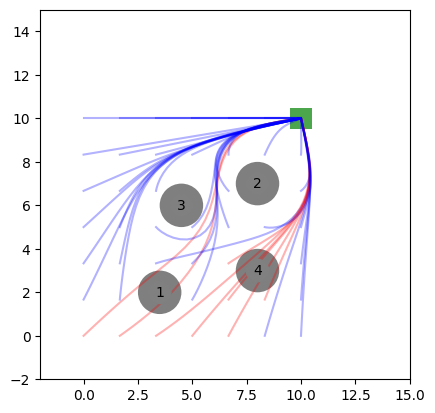

8


In [82]:
samples = 7
XS_Set, US_Set = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_irl, timeStep, max_iter, with_callback = False)
print(plot_tested_model(XS_Set, obs_set, target_high))